<a href="https://colab.research.google.com/github/palakagl/DeepLearning/blob/main/Trash_Classification_CV_Neptune.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Uncomment only for first run
!pip install neptune-client neptune-tensorflow-keras tensorflow

     |████████████████████████████████| 315 kB 5.7 MB/s 
     |████████████████████████████████| 829 kB 15.8 MB/s 
     |████████████████████████████████| 54 kB 805 kB/s 
     |████████████████████████████████| 181 kB 44.1 MB/s 
     |████████████████████████████████| 132 kB 22.4 MB/s 
     |████████████████████████████████| 8.6 MB 40.0 MB/s 
     |████████████████████████████████| 79 kB 1.8 MB/s 
     |████████████████████████████████| 138 kB 35.4 MB/s 
     |████████████████████████████████| 63 kB 995 kB/s 
     |████████████████████████████████| 127 kB 24.9 MB/s 
     |████████████████████████████████| 462 kB 43.6 MB/s 
     |████████████████████████████████| 130 kB 46.0 MB/s 
     |████████████████████████████████| 67 kB 5.8 MB/s 
     |████████████████████████████████| 64 kB 2.4 MB/s 
  Created wheel for neptune-client: filename=neptune_client-0.15.1-py2.py3-none-any.whl size=564805 sha256=112b5b4f0ed06c5ebbf03ea5ef12e2735ec9a6ba7e1ad91d7ac9ee9f51bd1881
  Stored in directory: /roo

In [ ]:

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime

import neptune.new as neptune
from neptune.new.integrations.tensorflow_keras import NeptuneCallback

import cv2
from google.colab.patches import cv2_imshow      # To show images using cv2 module

import pathlib
import os

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from keras.preprocessing.image import ImageDataGenerator

import tensorflow_hub as hub

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

TF version: 2.8.0
Hub version: 0.12.0
GPU is NOT AVAILABLE


In [ ]:
# Mount Google drive so dataset can be accessed
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
run = neptune.init(
    project="mohansameer/Trash-Classification-Deep-Learning",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI5ZjI5MDY4Yi0zMWVlLTQ3MmMtYjE4NS1iNDRjNGM0OTg4ZDkifQ==",
) 

https://app.neptune.ai/mohansameer/Trash-Classification-Deep-Learning/e/TRAS-15
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


# Model Selection

In [ ]:
  # Select base model  for transfer learning
  model_name = "efficientnet_v2_50" # @param [ 'efficientnet_v2_50', 'resnet_v1_50', 'resnet_v1_101', 'resnet_v1_152', 'resnet_v2_50', 'resnet_v2_101', 'resnet_v2_152',  'mobilenet_v2_100_224', 'mobilenet_v2_130_224', 'mobilenet_v2_140_224', 'mobilenet_v3_small_100_224', 'mobilenet_v3_small_075_224', 'mobilenet_v3_large_100_224', 'mobilenet_v3_large_075_224']

  model_handle_map = {
    "efficientnet_v2_50": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2",   
    "resnet_v1_50": "https://tfhub.dev/google/imagenet/resnet_v1_50/feature-vector/4",
    "resnet_v1_101": "https://tfhub.dev/google/imagenet/resnet_v1_101/feature-vector/4",
    "resnet_v1_152": "https://tfhub.dev/google/imagenet/resnet_v1_152/feature-vector/4",
    "resnet_v2_50": "https://tfhub.dev/google/imagenet/resnet_v2_50/feature-vector/4",
    "resnet_v2_101": "https://tfhub.dev/google/imagenet/resnet_v2_101/feature_vector/5",
    "resnet_v2_152": "https://tfhub.dev/google/imagenet/resnet_v2_152/feature-vector/4",
    "nasnet_large": "https://tfhub.dev/google/imagenet/nasnet_large/feature_vector/4",
    "nasnet_mobile": "https://tfhub.dev/google/imagenet/nasnet_mobile/feature_vector/4",
    "pnasnet_large": "https://tfhub.dev/google/imagenet/pnasnet_large/feature_vector/4",
    "mobilenet_v2_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4",
    "mobilenet_v2_130_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/feature_vector/4",
    "mobilenet_v2_140_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/feature_vector/4",
    "mobilenet_v3_small_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_small_100_224/feature_vector/5",
    "mobilenet_v3_small_075_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_small_075_224/feature_vector/5",
    "mobilenet_v3_large_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/feature_vector/5",
    "mobilenet_v3_large_075_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_large_075_224/feature_vector/5",
  }

  PIXELS = 224#@param {type:"integer"}
  BATCH_SIZE = 32#@param {type:"integer"}

  model_handle = model_handle_map.get(model_name)

  print(f"Selected model: {model_name} : {model_handle}")

  IMAGE_SIZE = (PIXELS, PIXELS)
  print(f"Input size {IMAGE_SIZE}")


Selected model: efficientnet_v2_50 : https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2
Input size (224, 224)


In [ ]:
#Log to NeptuneAI
run["model/transferlearning/model_name"] = model_name
run["model/transferlearning/model_url"] = model_handle
run["model/transferlearning/model_batch_size"] = BATCH_SIZE
run["model/parameters/image_size"] = IMAGE_SIZE

# Data Preparation

In [ ]:
def load_data(save_dir="./"):
  data_dir = pathlib.Path('/content/drive/MyDrive/Colab Notebooks/data/trash') 

  datagen_kwargs = dict(rescale=1./255, validation_split=0.2)
  dataflow_kwargs = dict(target_size=(PIXELS, PIXELS), 
                        batch_size=BATCH_SIZE,
                        interpolation="nearest")

  valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      **datagen_kwargs)

  valid_generator = valid_datagen.flow_from_directory(
      data_dir, subset="validation", 
      shuffle=False, **dataflow_kwargs)
  
  train_datagen = ImageDataGenerator(
            horizontal_flip=True,
            **datagen_kwargs)

  train_generator = train_datagen.flow_from_directory(
          data_dir, subset="training",
          class_mode='categorical',
          **dataflow_kwargs)
  return valid_generator, train_generator

VAL_generator, TRAIN_generator = load_data()

Found 288 images belonging to 28 classes.
Found 1212 images belonging to 28 classes.


In [ ]:
class_names = TRAIN_generator.class_indices.items()
print(class_names)

dict_items([('Aluminium foil', 0), ('Battery', 1), ('Blister pack', 2), ('Bottle', 3), ('Bottle cap', 4), ('Broken glass', 5), ('Can', 6), ('Carton', 7), ('Cigarette', 8), ('Cup', 9), ('Food waste', 10), ('Glass jar', 11), ('Lid', 12), ('Other plastic', 13), ('Paper', 14), ('Paper bag', 15), ('Plastic bag & wrapper', 16), ('Plastic container', 17), ('Plastic glooves', 18), ('Plastic utensils', 19), ('Pop tab', 20), ('Rope & strings', 21), ('Scrap metal', 22), ('Shoe', 23), ('Squeezable tube', 24), ('Straw', 25), ('Styrofoam piece', 26), ('Unlabeled litter', 27)])


# Modelling

## Build and Train Model


In [ ]:
def build_model(trainable=False, params={}):
   print("Building model with", model_handle)
   # Download the pretrained model and save it as a Keras layer
   feature_extractor_layer = hub.KerasLayer(model_handle,
                                           trainable=trainable, # freeze the underlying patterns
                                           name='feature_extraction_layer',
                                           input_shape=IMAGE_SIZE+(3,)) # define the input image shape
                                           
   model = keras.Sequential([
        feature_extractor_layer,
        keras.layers.Dense(params['dense_units_1'],activation=params['dense_layer_activation_1']),
        keras.layers.Dropout(params['dropout']),
        keras.layers.Dense(TRAIN_generator.num_classes,
                              kernel_regularizer=tf.keras.regularizers.l2(params['regularizer_rate']))])
   model.build((None,)+IMAGE_SIZE+(3,))
   model.summary()
   return model

params = {
    "dense_units_1": 128,
    "dense_layer_activation_1": "relu",
    "regularizer_rate":0.005,
    "dropout": 0.1,
    "learning_rate": 0.01,
    "n_epochs": 20,
}
run["model/parameters"] = params
model = build_model(params=params)

Building model with https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             5919312   
 erasLayer)                                                      
                                                                 
 dense_4 (Dense)             (None, 128)               163968    
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 28)                3612      
                                                                 
Total params: 6,086,892
Trainable params: 167,580
Non-trainable params: 5,919,312
_________________________________________________________________


In [ ]:
def compile_model(model):
  model.compile(
    optimizer=tf.keras.optimizers.SGD(lr=params['learning_rate'], momentum=0.8), 
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
  metrics=['accuracy'])
  return model

model = compile_model(model)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
# Add Callbacks

# Model Checkpoint
tl_checkpoint_1 = ModelCheckpoint(filepath = '/content/drive/MyDrive/Colab Notebooks/Models/garbageclassification_model_checkpoint/resnet_best_weights.hdf5', save_best_only = True, verbose = 0)

# Early Stopping Checkpoint
EarlyStoppingCallback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

In [ ]:
def train_model(model, num_epochs):

    steps_per_epoch = TRAIN_generator.samples // TRAIN_generator.batch_size
    validation_steps = VAL_generator.samples // VAL_generator.batch_size

    history = model.fit(
      TRAIN_generator,
      epochs=num_epochs, steps_per_epoch=steps_per_epoch,
      validation_data = VAL_generator,
      validation_steps = validation_steps,
      callbacks=[NeptuneCallback(run=run), EarlyStoppingCallback]).history
    
    return model, history

model, history = train_model(model, num_epochs=params['n_epochs'])

Epoch 1/20
37/37 [==============================] - 188s 5s/step - loss: 3.1644 - accuracy: 0.2119 - val_loss: 2.9804 - val_accuracy: 0.2431
Epoch 2/20
37/37 [==============================] - 177s 5s/step - loss: 2.8743 - accuracy: 0.2780 - val_loss: 2.9440 - val_accuracy: 0.2569
Epoch 3/20
37/37 [==============================] - 176s 5s/step - loss: 2.7599 - accuracy: 0.3153 - val_loss: 2.9206 - val_accuracy: 0.2604
Epoch 4/20
37/37 [==============================] - 177s 5s/step - loss: 2.6890 - accuracy: 0.3364 - val_loss: 2.9050 - val_accuracy: 0.2778
Epoch 5/20
37/37 [==============================] - 177s 5s/step - loss: 2.6007 - accuracy: 0.3661 - val_loss: 2.9188 - val_accuracy: 0.2639
Epoch 6/20
37/37 [==============================] - 177s 5s/step - loss: 2.5285 - accuracy: 0.3907 - val_loss: 2.9115 - val_accuracy: 0.2812


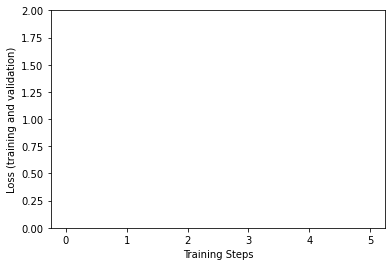

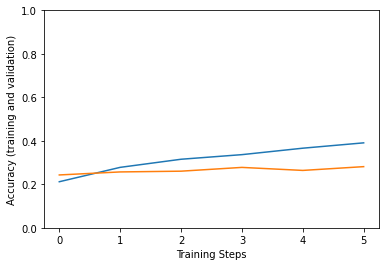

In [ ]:
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(history["loss"])
plt.plot(history["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(history["accuracy"])
plt.plot(history["val_accuracy"])

In [ ]:
# Generate predictions
model.load_weights('/content/drive/MyDrive/Colab Notebooks/Models/garbageclassification_model_checkpoint/resnet_best_weights.hdf5') # initialize the best trained weights
preds = model.predict(test_ds)
pred_classes = np.argmax(preds, axis = 1)

OSError: ignored

# Save Model

In [ ]:
saved_model_path = "/content/drive/MyDrive/Colab Notebooks/Models/saved_garbageclassification_model"
tf.saved_model.save(model, saved_model_path)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/Models/saved_garbageclassification_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/Models/saved_garbageclassification_model/assets


# Fine Tuning